## Library imports & HTML loading

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import undetected_chromedriver as uc
from selenium.webdriver.common.by import By
from bs4 import BeautifulSoup
import time

## Exploring & Inspecting HTML

In [ ]:
# After taking a look at the HTML using "inspect element" feature
# I found that the div where job cars are stored begins with "JobCard_jobCardContainer"
# So, I will use this to search for all the other tags that will be useful for me

# This script opens Glassdoor in an undetected Chrome browser, scrolls and clicks “Show More”
# to load all job listings, then gets the HTML page and parses it with BeautifulSoup for scraping job details.

options = uc.ChromeOptions()
options.add_argument("--disable-blink-features=AutomationControlled")
options.add_argument("--start-maximized")
driver = uc.Chrome(options=options)
driver.get("https://www.glassdoor.com/Job/new-york-data-analyst-jobs-SRCH_IL.0,8_IC1132348_KO9,21.htm")

for i in range(20):
    driver.execute_script(f"window.scrollBy(0, 1200);")
    time.sleep(3)
    try:
        show_more = driver.find_element(By.CSS_SELECTOR, "button[data-test='load-more']")
        if show_more.is_displayed():
            show_more.click()
            time.sleep(5)
    except:
        pass

html = driver.page_source
soup = BeautifulSoup(html, "html.parser")

def hascontainer(classname):
    if (classname != None) and ("JobCard_jobCardContainer" in classname):
        return True

jobs = soup.find_all("div", class_=hascontainer)
print(len(jobs))

driver.quit()

 #first_job = soup.find("div", class_='hascontainer')

# for tag in first_job.find_all(True):
#    print(tag.name, tag.get("class"), tag.get_text())

# After running the code we can see that the follwing tags contain what we want to scrap:
# 1) span ['EmployerProfile_compactEmployerName__9MGcV'] Lyft
# 2) span ['rating-single-star_RatingText__XENmU'] 3.7
# 3) a ['JobCard_jobTitle__GLyJ1'] Data Analyst
# 4) div ['JobCard_location__Ds1fM'] New York, NY
# 5) div ['JobCard_salaryEstimate__QpbTW'] $90K - $112K (Employer provided)
# 6) div ['JobCard_listingAge__jJsuc'] 13d


522


## Scraping and Converting to a Dataframe

In [170]:
# Jobs will hold the values we scrap
jobs = []

# These functions are just helper functions, since the class tag for each
# job is different but has the same starting I will need to check if that class
# contains certian words or not 
def hasjobcard(classname):
    if (classname != None) and ("JobCardWrapper" in classname):
        return True
    return False
def hascompany(classname):
    if (classname != None) and ("EmployerProfile_compactEmployerName" in classname):
        return True
    return False
def hastitle(classname):
    if (classname != None) and ("JobCard_jobTitle" in classname):
        return True
    return False
def hasrating(classname):
    if (classname != None) and ("rating-single-star_RatingText" in classname):
        return True
    return False
def haslocation(classname):
    if (classname != None) and ("JobCard_location" in classname):
        return True
    return False
def hassalary(classname):
    if (classname != None) and ("JobCard_salaryEstimate" in classname):
        return True
    return False
def hassage(classname):
    if (classname != None) and ("JobCard_listingAge" in classname):
        return True
    return False

# Loop inside the larger div containing all the information we need
# and extract the text only, after that I will append it into jobs
for job_card in soup.find_all("div", class_=hasjobcard):
    
    company_tag  = job_card.find("span", class_=hascompany)
    company = company_tag.get_text(strip=True) if company_tag else None

    title_tag = job_card.find("a", class_=hastitle)
    title = title_tag.get_text(strip=True) if title_tag else None

    rating_tag = job_card.find("span", class_=hasrating)
    rating = rating_tag.get_text(strip=True) if rating_tag else None

    location_tag = job_card.find("div", class_=haslocation)
    location = location_tag.get_text(strip=True) if location_tag else None

    salary_tag = job_card.find("div", class_ =hassalary)
    salary = salary_tag.get_text(strip=True) if salary_tag else None

    age_tag = job_card.find("div", class_=hassage)
    age = age_tag.get_text(strip=True) if age_tag else None

    jobs.append([company, title, rating, location, salary, age])

# Convert jobs, into a dataframe for analysis
df = pd.DataFrame(jobs, columns=["Company","Title", "Rating", "Location", "Salary", "Date_Posted"])
df

,Company,Title,Rating,Location,Salary,Date_Posted
0,Public Health Solutions,Data Analyst,4.0,"New York, NY",$70K(Employer provided),3d
1,Lemonade,Data Analyst,3.7,"New York, NY",$90K - $110K(Employer provided),4d
2,DEPARTMENT OF FINANCE,Data Analyst,3.7,Manhattan,$94K - $101K(Employer provided),3d
3,Visiting Nurse Service of New York d/b/a VNS H...,Data Analyst,3.1,"New York, NY",$77K - $116K(Employer provided),5d
4,Lyft,Data Analyst,3.7,"New York, NY",$90K - $112K(Employer provided),13d
...,...,...,...,...,...,...
517,Neotecra inc,PEOPLESOFT BUSINESS ANALYST FUNCTIONAL LEAD(W2...,3.9,"New York, NY",$60.00 - $67.43 Per Hour(Employer provided),27d
518,Heartshare Human Services Of New York,Bilingual Program Analyst (English / Spanish),3.1,"Brooklyn, NY",$33.61 Per Hour(Employer provided),30d+
519,Blue State,Principal Analyst (Evergreen),3.0,"New York, NY",$112K - $125K(Employer provided),30d+
520,"Amazon Web Services, Inc.","Senior Betting & Gaming Delivery Consultant, A...",3.7,"New York, NY",$138K - $239K(Employer provided),24h


## Handle Datatypes & Missing Values

In [175]:
df.isna().sum()

Company        0
Title          0
Rating         0
Location       0
Salary         0
Date_Posted    0
dtype: int64

In [174]:
df = df.dropna(subset=['Rating', 'Salary'])

In [176]:
df.dtypes

Company        object
Title          object
Rating         object
Location       object
Salary         object
Date_Posted    object
dtype: object

In [177]:
df['Rating'] = df['Rating'].astype(float)

def convert_date(value):
    if "h" in value:
        return 0
    else:
        return value

df['Date_Posted'] = df['Date_Posted'].str.replace("d", "").str.replace("+", "").apply(convert_date).astype(int)

In [178]:
def convert_salary(value):
    
    numbers = re.findall(r"\$?(\d+(?:\.\d+)?)", value)
    numbers = [float(n) for n in numbers]

    if "Per" in value:
        return (sum(numbers) / 2) * 40 * 52
    else:
        return (sum(numbers) / 2) * 1000

df['Salary'] = df['Salary'].apply(convert_salary)

## Visualizations

### Top 10 Job Titles

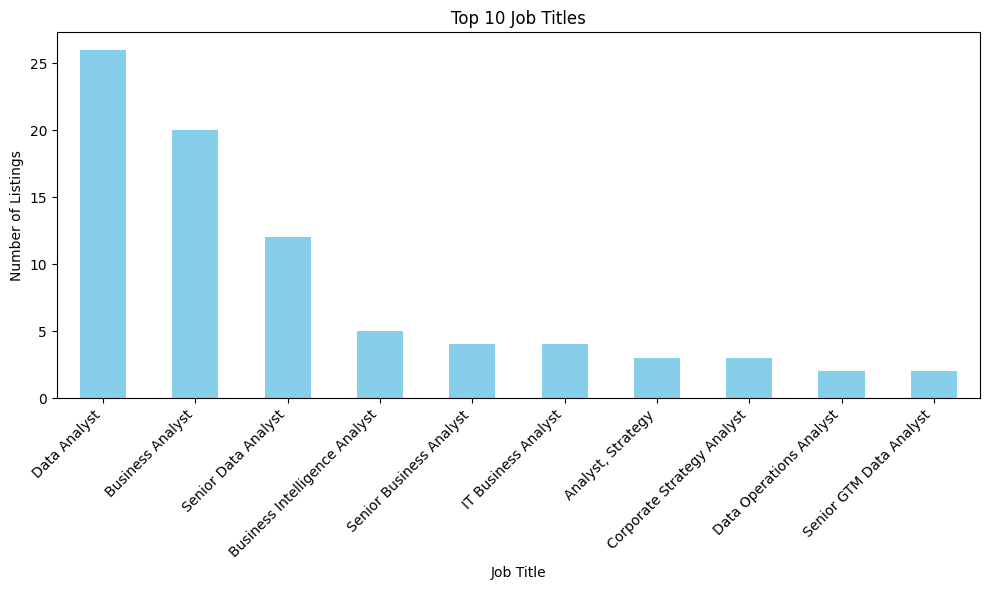

In [190]:
plt.figure(figsize=(10,6))
df['Title'].value_counts().head(10).plot(kind='bar', color='skyblue')
plt.title('Top 10 Job Titles')
plt.xlabel('Job Title')
plt.ylabel('Number of Listings')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


### Salary vs Ratings

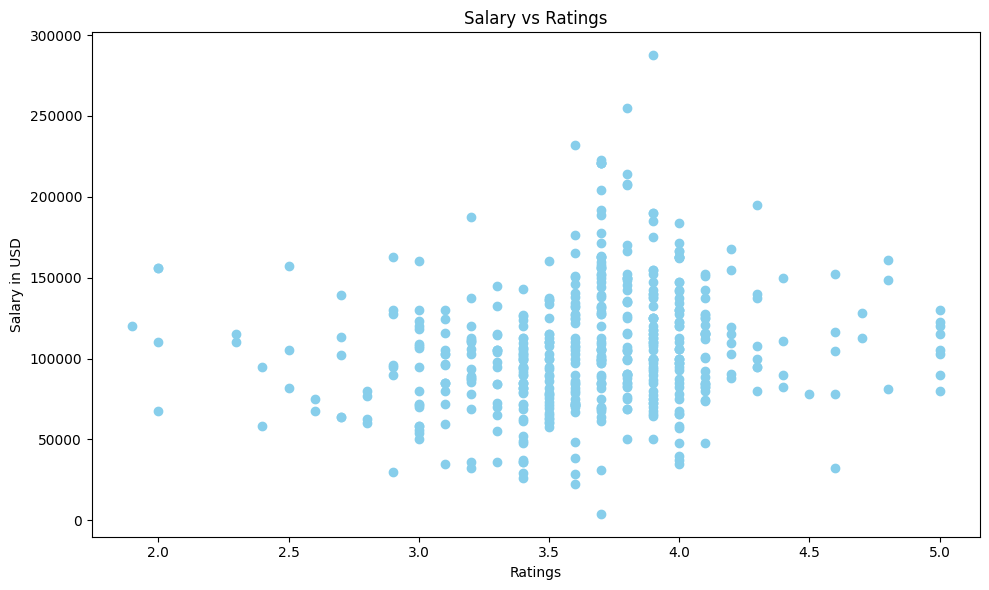

In [192]:
plt.figure(figsize=(10,6))
plt.scatter(x= df['Rating'], y = df['Salary'], color='skyblue')

plt.title('Salary vs Ratings')
plt.xlabel('Ratings')
plt.ylabel('Salary in USD')
plt.tight_layout()
plt.show()

### Salary Distribution

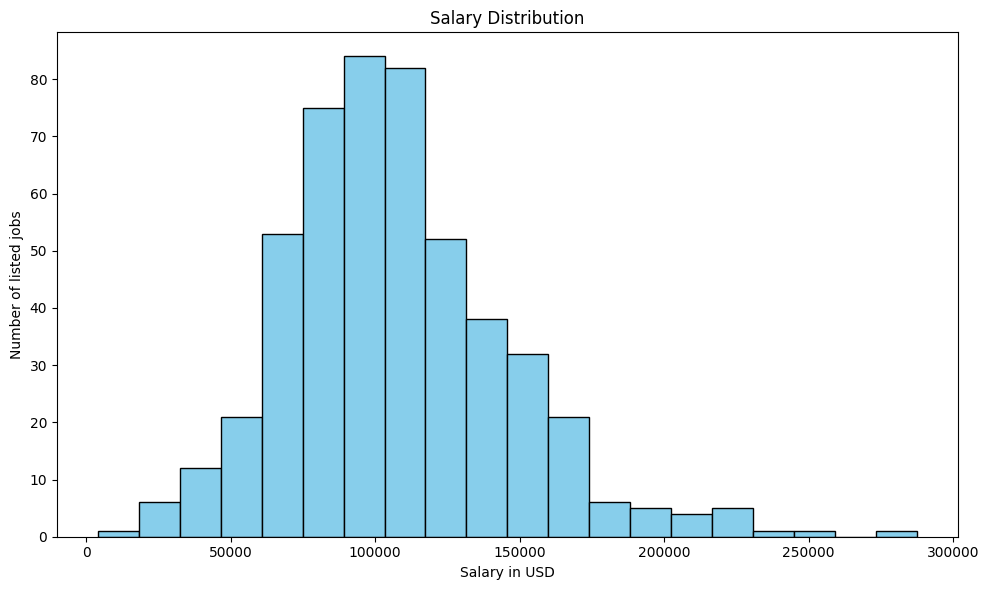

In [199]:
plt.figure(figsize=(10,6))
plt.hist(df['Salary'], color = 'skyblue', edgecolor='black', bins=20)

plt.title('Salary Distribution')
plt.xlabel('Salary in USD')
plt.ylabel('Number of listed jobs')
plt.tight_layout()
plt.show()

### Top 10 Best and Worst Rated Companies

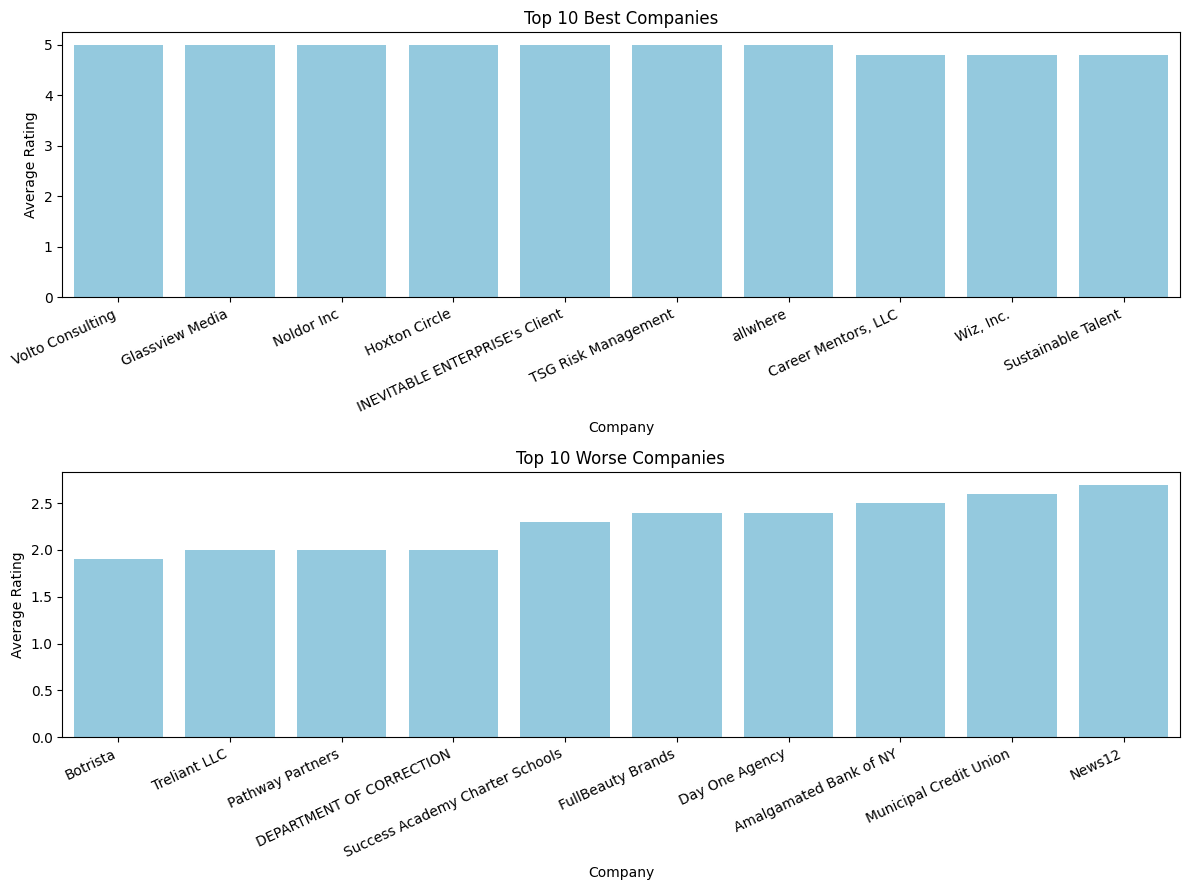

In [220]:
ratings = df.groupby('Company')['Rating'].mean()
top10 = ratings.sort_values(ascending=False).head(10)
plt.figure(figsize=(12,9))
plt.subplot(2, 1, 1)

sns.barplot(x=top10.index, y=top10.values, color='skyblue')
plt.xticks(rotation=25, ha='right')
plt.title('Top 10 Best Companies')
plt.xlabel('Company')
plt.ylabel('Average Rating')
plt.tight_layout()

bottom10 = ratings.sort_values(ascending=True).head(10)
plt.subplot(2, 1, 2)
sns.barplot(x=bottom10.index, y=bottom10.values, color='skyblue')
plt.xticks(rotation=25, ha='right')
plt.title('Top 10 Worse Companies')
plt.xlabel('Company')
plt.ylabel('Average Rating')
plt.tight_layout()

plt.show()